# Saws Capstone Project

## Introduction

The San Antonio Water System (SAWS) has collected a dataset of over 3100 Sanitary Sewer Overflow (SSO) events going back to 2009. The data on these events contains a wealth of information about the event, including the root cause that was determined. We know that some of the events are weather related so we will be using data collected by National Oceanic and Atomospheric Administration (NOAA) in combination with the SSO events to provide better insights into what causes these events. It is our hope that these insights can be used by the city of San Antonio and SAWS to plan preventative measures that will benefit the city in the future.

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', None)

from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn import tree
from scipy import stats

import graphviz
from graphviz import Graph

import warnings
warnings.filterwarnings("ignore")

import acquire
import explore
import prepare
import preprocessing

<Figure size 1152x576 with 0 Axes>

## Acquire

### Acquisition of San Antonio Sanitary Sewer Overflow (SSO) Data

The SSO data is collected from the CivTech San Antonio's Datathon website. [CivTechSA](https://www.civtech-sa.com/datathon/)

Data use in this notebook can be found here: [Datathon SSO data](https://storage.googleapis.com/sa_saws_data/SAWS_SSOs_2009-2018Mar_UploadData.xlsx)
* The data includes information on age of sewer, initial reported causes, and investigation reported causes  .

In [2]:
sso = acquire.acquire_sso()
sso

,SSO_ID,INSPKEY,SERVNO,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,SPILL_STOP,HRS,CAUSE,COMMENTS,ACTIONS,WATERSHED,UNITID,UNITID2,DISCHARGE_TO,DISCHARGE_ROUTE,COUNCIL_DISTRICT,FERGUSON,Month,Year,Week,EARZ_ZONE,Expr1029,PIPEDIAM,PIPELEN,PIPETYPE,INSTYEAR,DWNDPTH,UPSDPTH,Inches_No,RainFall_Less3,SPILL ADDRESS,SewerAssetExp,NUM_SPILLS_COMPKEY,NUM_SPILLS_24MOS,PREVSPILL_24MOS,UNITTYPE,ASSETTYPE,LASTCLND,ResponseTime,ResponseDTTM,Public Notice,TIMEINT,Root_Cause,STEPS_TO_PREVENT,SPILL_START_2,SPILL_STOP_2,HRS_2,GAL_2,SPILL_START_3,SPILL_STOP_3,HRS_3,GAL_3
0,6582,567722.0,NaN,2019-03-10 00:00:00,3200,THOUSAND OAKS DR,2100,2100.0,2100.0,3/10/2019 1:16:00 PM,3/10/2019 2:40:00 PM,1.400000,Grease,Spill ContainedReturned to SystemArea Cleaned ...,CLEANED MAIN,SALADO CREEK,66918,66917,STREET,None,NaN,172A2,3,2019,11,0.0,NaN,8.0,16.550000,PVC,1997.0,NaN,NaN,NaN,NaN,3200 THOUSAND OAKS DR,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,0.450000,2019-03-10 13:43:00,False,24.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
1,6583,567723.0,NaN,2019-03-10 00:00:00,6804,S FLORES ST,80,0.0,80.0,3/10/2019 2:25:00 PM,3/10/2019 3:45:00 PM,1.333333,Grease,Spill ContainedArea Cleaned and Disinfected,CLEANED MAIN,DOS RIOS,24250,24193,STORMDRAIN,None,3.0,251A3,3,2019,11,0.0,NaN,8.0,157.000000,PVC,1988.0,NaN,NaN,NaN,NaN,6804 S FLORES,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,1.083333,2019-03-10 15:30:00,False,120.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
2,6581,567714.0,NaN,2019-03-09 00:00:00,215,AUDREY ALENE DR,79,0.0,10.0,3/9/2019 6:00:00 PM,3/9/2019 7:30:00 PM,1.500000,Structural,Spill ContainedArea Cleaned and DisinfectedFlu...,CLEANED MAIN,DOS RIOS,2822,3351,ALLEY,None,1.0,190E4,3,2019,10,0.0,NaN,8.0,350.000000,CP,1955.0,NaN,NaN,NaN,NaN,215 Audrey Alene Dr,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,1.000000,2019-03-09 19:00:00,False,24.0,NaN,NaN,03/10/2019 09:36,03/10/2019 10:45,1.15,69.0,NaN,NaN,0.0,0.0
3,6584,567713.0,NaN,2019-03-09 00:00:00,3602,SE MILITARY DR,83,0.0,83.0,3/9/2019 3:37:00 PM,3/9/2019 5:00:00 PM,1.383333,Grease,Spill ContainedArea Cleaned and DisinfectedFlu...,NaN,SALADO CREEK,92804,92805,EASEMENT,None,3.0,252C3,3,2019,10,0.0,NaN,8.0,213.910000,PVC,1983.0,NaN,NaN,NaN,NaN,3602 SE MILITARY DR,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,0.550000,2019-03-09 16:10:00,False,120.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
4,6580,567432.0,NaN,2019-03-06 00:00:00,100,PANSY LN,75,0.0,75.0,3/6/2019 9:40:00 AM,3/6/2019 9:55:00 AM,0.250000,Structural,Spill ContainedArea Cleaned and DisinfectedFlu...,CLEANED MAIN,SALADO CREEK,61141,49543,STREET,None,2.0,192A7,3,2019,10,0.0,NaN,12.0,291.900000,CP,1952.0,NaN,NaN,NaN,NaN,100 PANSY LN,NaN,2,2.0,2018-12-15 00:00:00,GRAVITY,Sewer Main,NaN,0.000000,2019-03-06 09:40:00,False,3.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,371,NaN,NaN,2009-01-06 00:00:00,2383,LOOP 410 NE,2000,NaN,2000.0,1/6/2009 12:00:00 PM,1/6/2009 1:00:00 PM,1.000000,Debris/Rock,CLEANED MAIN,APPLIED HTH,SALADO CREEK,46343,59920,DRAINAGE CULVERT,NaN,10.0,552B8,1,2009,2,NaN,STRUCTURAL,8.0,400.000000,VCP,1966.0,NaN,NaN,NaN,NaN,NE LOOP 410 02383,NaN,1,NaN,NaN,GRAVITY,Sewer Main,NaN,NaN,NaN,False,NaN,STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179,372,NaN,NaN,2009-01-05 00:00:00,7407,ELDERBERRY,800,NaN,800.0,1/5/2009 2:00:00 PM,1/5/2009 4:00:00 PM,2.000000,Rags,CLEANED MAIN,APPLIED HTH,LEON CREEK,89038,74015,STREET,NaN,7.0,547F7,1,2009,2,NaN,STRUCTURAL,8.0,151.877494,VCP,1976.0,NaN,NaN,NaN,NaN,ELDERBERRY 07407,2009-10-09 09:21:05,2,NaN,NaN,GRAVITY,Sewer Main,NaN,NaN,NaN,False,NaN,STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3180,373,NaN,NaN,2009-01-05 00:00:00,7019,BAYWATER,400,NaN,400.0,1/5/2009 11:00:00 AM,1/5/2009 11:45:00 AM,0.750000,Rags,CLEANED MAIN,APPLIED HTH,LEON CREEK,51874,51883,DRAINAGE CULVERT,Na

### Acquisition of Weather Data




The weather data is collected from the National Centers for Environmental Information API. Documentation for the API can be found here: [NCEI API](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation)
The API request can be found in the acquire file but the details are as follows:
* The data is from the San Antonio International Airport
* The data is the daily summary from December 3, 2008 to April 3, 2019
    * While this is outside the range of the SSO events data, we have done this so that we can take rolling averages up to a month before the first event.
* The data includes information on precipitation, wind, temperature, and a vast number of meteorological events.
* The units for these recording are in standard format.

In [3]:
weather = acquire.acquire_weather()
weather

,STATION,DATE,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT05,WT06,WT07,WT08,WT09,WT10,WT11,WT13,WT16,WT17,WT18,WT19
0,USW00012921,2008-12-03,9.40,2302.0,2315.0,0.0,0.0,0.0,NaN,77,48,360,350.0,19.9,38.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,USW00012921,2008-12-04,11.41,828.0,506.0,0.0,0.0,0.0,NaN,61,39,20,350.0,21.0,29.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00012921,2008-12-05,6.71,952.0,839.0,0.0,0.0,0.0,NaN,55,36,20,30.0,15.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00012921,2008-12-06,3.80,1157.0,1132.0,0.0,0.0,0.0,NaN,69,30,240,270.0,10.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00012921,2008-12-07,6.93,1557.0,1512.0,0.0,0.0,0.0,NaN,71,36,160,190.0,17.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,USW00012921,2019-03-30,13.87,NaN,NaN,0.0,0.0,0.0,67.0,70,51,10,20.0,32.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3770,USW00012921,2019-03-31,10.96,NaN,NaN,0.0,0.0,0.0,52.0,59,44,20,30.0,25.1,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3771,USW00012921,2019-04-01,5.59,NaN,NaN,0.0,0.0,0.0,51.0,62,42,130,130.0,12.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3772,USW00012921,2019-04-02,8.05,NaN,NaN,0.0,0.0,0.0,53.0,71,37,150,160.0,18.1,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preparation

### Preparation of SSO Data

- What are we changing?
    - We are removing columns that are listed as 'ignore' in the data dictionary provided along with the SSO data, as well as columns that are entirely null
    - We change the column names to make them more understandable, we change the data types of some columns to work with them better, we impute some values to 0 or None, we replace many columns 'NaN's with 'unknown'
    - We add 'days since cleaned', 'age', and 'number of hours spilled' columns
    - We use geopy to take the street addresses and find the aligning ZIP codes. We turned that into a csv since it takes a very long time to do, so if you want to do this yourself, take that into account
    - We add columns that turn age and gallons spilled into categorical bins

In [4]:
sso = prepare.prepare_sso_with_zipcodes()

### Preparation of Weather Data

* What are we changing?
    * We are removing columns that are don't provide a lot of information.
        * "STATION","AWND", "FMTM", "PGTM", "WDF2", "WDF5", "WSF2", "WSF5", "WT06", "WT07", "WT08", "WT10", "WT11", "WT13", "WT17", "WT18", "WT19"
    * We changed the column names to make them more understandable.
    * We imputed some missing values
        * avg_temp was missing some values so we imputed with `(max_temp + min_temp ) / 2`
        * All of the weather event columns are missing the 0 for if the event didn't happen that day so we replace NaNs with 0.
    * We added rolling averages for precipitation, avg_temp, max_temp, and min_temp
        * These were added at 7, 14, and 30 day periods

In [5]:
prepare.prep_weather_data()

,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
date,,,,,,,,,,,,,,,,,,,,,,,,
2008-12-03,0.0,0.0,0.0,62.5,77,48,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-04,0.0,0.0,0.0,50.0,61,39,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-05,0.0,0.0,0.0,45.5,55,36,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-06,0.0,0.0,0.0,49.5,69,30,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-07,0.0,0.0,0.0,53.5,71,36,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-30,0.0,0.0,0.0,67.0,70,51,0,0,0,0,0,0,1.428571e-03,0.019286,0.015333,68.000000,64.142857,60.733333,78.571429,75.142857,70.600000,58.428571,54.142857,51.266667
2019-03-31,0.0,0.0,0.0,52.0,59,44,0,0,0,0,0,0,1.428571e-03,0.019286,0.015000,65.571429,64.071429,60.833333,75.428571,74.785714,70.633333,55.428571,54.285714,51.200000
2019-04-01,0.0,0.0,0.0,51.0,62,42,0,0,0,0,0,0,1.103532e-15,0.019286,0.015000,62.428571,63.785714,60.666667,72.000000,74.357143,70.666667,52.428571,54.142857,50.833333


### Joining SSO and Weather Data

After we have prepared both datasets we are now able to join the SSO events on to the weather data by date.

In [6]:
df = prepare.get_data()
df

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,inst_year,inches_no,rainfall_last3,spill_address_full,num_spills_recorded,num_spills_24mos,prevspill_24mos,unit_type,asset_type,last_cleaned,response_time,response_dttm,public_notice,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,total_gal_binned,country_address,location,zip_code,age,age_binned,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
0,6582,2019-03-10,3200,THOUSAND OAKS DR,2100,2100.0,2019-03-10 13:16:00,2019-03-10 14:40:00,1.400000,Grease,Spill ContainedReturned to SystemArea Cleaned ...,CLEANED MAIN,SALADO CREEK,66918,66917,STREET,None,NaN,3,2019,11,0,8.0,16.550000,PVC,1997.0,NaN,NaN,3200 THOUSAND OAKS DR,1,1.0,0,GRAVITY,Sewer Main,NaN,27.0,2019-03-10 13:43:00,False,other,0.00,0.0,0.0,0.0,164.0,"(1000, 5000]","3200 THOUSAND OAKS DR,SAN ANTONIO,Texas,USA","3200, Thousand Oaks Drive, Horseshoe Bend, Los...",78746,22.0,"(20, 25]",1.400000,0.00,0.0,0.0,69.0,79,60,1,1,0,0,0,0,4.285714e-03,0.005714,0.016333,54.285714,55.285714,54.200000,65.857143,65.714286,64.533333,46.000000,47.642857,45.900000
1,6583,2019-03-10,6804,S FLORES ST,80,0.0,2019-03-10 14:25:00,2019-03-10 15:45:00,1.333333,Grease,Spill ContainedArea Cleaned and Disinfected,CLEANED MAIN,DOS RIOS,24250,24193,STORMDRAIN,None,3.0,3,2019,11,0,8.0,157.000000,PVC,1988.0,NaN,NaN,6804 S FLORES,1,1.0,0,GRAVITY,Sewer Main,NaN,65.0,2019-03-10 15:30:00,False,other,0.00,0.0,0.0,0.0,164.0,"(50, 250]","6804 S FLORES,SAN ANTONIO,Texas,USA","Flores, West Odessa, Ector County, Texas, Unit...",Texas,31.0,"(30, 35]",1.333333,0.00,0.0,0.0,69.0,79,60,1,1,0,0,0,0,4.285714e-03,0.005714,0.016333,54.285714,55.285714,54.200000,65.857143,65.714286,64.533333,46.000000,47.642857,45.900000
2,6581,2019-03-09,215,AUDREY ALENE DR,79,0.0,2019-03-09 18:00:00,2019-03-09 19:30:00,1.500000,Structural,Spill ContainedArea Cleaned and DisinfectedFlu...,CLEANED MAIN,DOS RIOS,2822,3351,ALLEY,None,1.0,3,2019,10,0,8.0,350.000000,CP,1955.0,NaN,NaN,215 Audrey Alene Dr,1,1.0,0,GRAVITY,Sewer Main,NaN,60.0,2019-03-09 19:00:00,False,other,1.15,69.0,0.0,0.0,164.0,"(50, 250]","215 Audrey Alene Dr,SAN ANTONIO,Texas,USA","215, Audrey Alene Drive, San Antonio, Bexar Co...",78216,64.0,"(60, 65]",1.500000,0.03,0.0,0.0,74.0,87,60,1,0,0,0,0,0,4.285714e-03,0.005714,0.016333,51.714286,54.357143,53.300000,62.142857,64.785714,63.333333,42.571429,46.714286,45.133333
3,6584,2019-03-09,3602,SE MILITARY DR,83,0.0,2019-03-09 15:37:00,2019-03-09 17:00:00,1.383333,Grease,Spill ContainedArea Cleaned and DisinfectedFlu...,NaN,SALADO CREEK,92804,92805,EASEMENT,None,3.0,3,2019,10,0,8.0,213.910000,PVC,1983.0,NaN,NaN,3602 SE MILITARY DR,1,1.0,0,GRAVITY,Sewer Main,NaN,33.0,2019-03-09 16:10:00,False,other,0.00,0.0,0.0,0.0,164.0,"(50, 250]","3602 SE MILITARY DR,SAN ANTONIO,Texas,USA","Quality Suites, Southeast Military Drive, Hill...",78223,36.0,"(35, 40]",1.383333,0.03,0.0,0.0,74.0,87,60,1,0,0,0,0,0,4.285714e-03,0.005714,0.016333,51.714286,54.357143,53.300000,62.142857,64.785714,63.333333,42.571429,46.714286,45.133333
4,6580,2019-03-06,100,PANSY LN,75,0.0,2019-03-06 09:40:00,2019-03-06 09:55:00,0.250000,Structural,Spill ContainedArea Cleaned and DisinfectedFlu...,CLEANED MAIN,SALADO CREEK,61141,49543,STREET,None,2.0,3,2019,10,0,12.0,291.900000,CP,1952.0,NaN,NaN,100 PANSY LN,2,2.0,2018-12-15 00:00:00,GRAVITY,Sewer Main,NaN,0.0,2019-03-06 09:40:00,False,other,0.00,0.0,0.0,0.0,164.0,"(50, 250]","100 PANSY LN,SAN ANTONIO,Texas,USA","Pansy Lane, San Antonio, Bexar County, Tex

### Train, Test Split
##### Final, we will split our data into:
- train = 80%
- test = 20%

In [7]:
train, test = train_test_split(df, train_size=.8, random_state=123)

## Exploration


### Does the age of the sewer drive certain root causes? 

Main Hypothesis:
- $H_0$: The age of the sewer and the root cause are not related.
- $H_a$: The age of the sewer and the root cause are related.

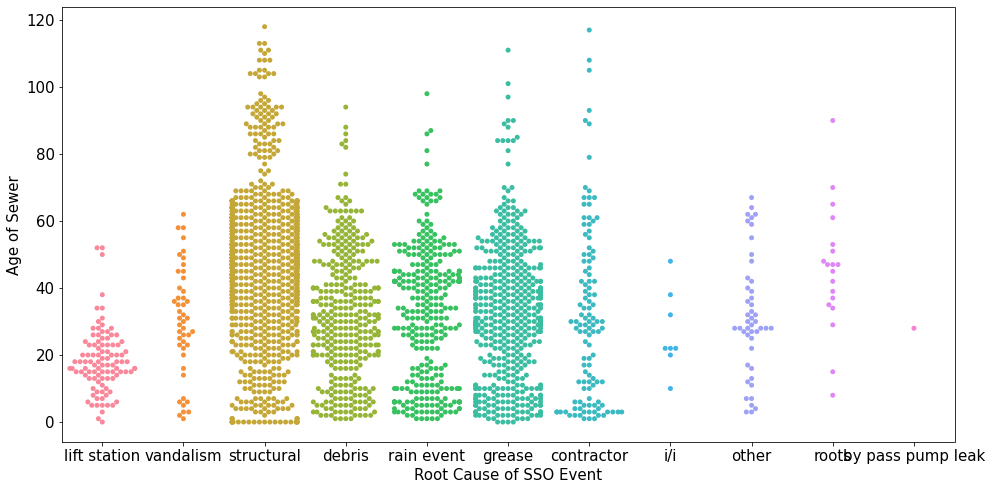



Hypothesis Testing:
H_null: The age of the sewer is not correlated as the cause of the pipe damage involving a root_cause.
H_alt: The age of the sewer is correlated as the cause of the pipe damage involving a root cause.

Root Causes: 
	structural, grease, debris, rain event, contractor, lift station, other, vandalism, roots, i/i, by pass pump leak, 

We reject the null hypothesis that the age of the sewer is not correlated as the cause of the pipe damage invloving: 

----------------------------------------------------------------------------------------------------
We fail to reject the null hypothesis that the age of the sewer is not correlated as the cause of the pipe damage invloving: 

 structural with an alpha of 0.01 and a p-value of nan:
 grease with an alpha of 0.01 and a p-value of nan:
 debris with an alpha of 0.01 and a p-value of nan:
 rain event with an alpha of 0.01 and a p-value of nan:
 contractor with an alpha of 0.01 and a p-value of nan:
 lift station with an alp

In [8]:
explore.explore_age(train)


**Main Hypothesis:** restated
- $H_0$: The age of the sewer and the root cause are not related.
- $H_a$: The age of the sewer and the root cause are related.

- since we reject the null hypothesis for the following root causes, we must reject the main null hypothesis:
    - structural 
    - grease 
    - debris
    - rain event
    - lift station
    - vandalism

### Does the amount of rain drive certain root causes?

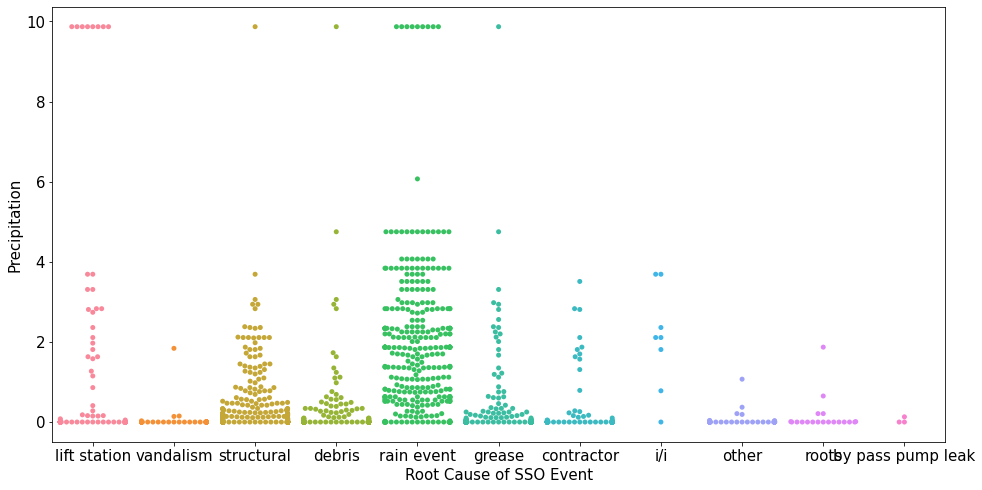



Hypothesis Testing:
H_null: The amount of rainfall is not correlated as the cause of the pipe damage involving a root_cause.
H_alt: The amount of rainfall is correlated as the cause of the pipe damage involving a root cause.

Root Causes: 
	structural, grease, debris, rain event, contractor, lift station, other, vandalism, roots, i/i, by pass pump leak, 

We reject the null hypothesis that the amount of rainfall is not correlated as the cause of the pipe damage invloving: 

 structural with an alpha of 0.01 and a p-value of 1.7102838954174988e-60:
 grease with an alpha of 0.01 and a p-value of 6.041108950661502e-20:
 debris with an alpha of 0.01 and a p-value of 4.532868889599897e-15:
 rain event with an alpha of 0.01 and a p-value of 2.0801691583820262e-38:
 contractor with an alpha of 0.01 and a p-value of 3.912296729165289e-06:
 lift station with an alpha of 0.01 and a p-value of 0.006100756598997433:
 other with an alpha of 0.01 and a p-value of 4.650654768977534e-21:
 vandalism 

In [9]:
explore.explore_rainfall(train)

**Main Hypothesis:** restated
- $H_0$: The amount of rainfall and the root cause are not related.
- $H_a$: The amount of rainfall and the root cause are related.

- since we reject the null hypothesis for the following root causes, we must reject the main null hypothesis:
    - structural 
    - grease 
    - debris
    - rain event
    - lift station
    - vandalism
    - contractor
    - i/i
    - other

### Does whether or not it rained drive certain root causes?

Contingency Table
rain                 0    1
root_cause                 
by pass pump leak    3    0
contractor         133    6
debris             295   70
grease             419   70
i/i                  1    7
lift station        90   21
other               46    4
rain event         283   43
roots               18    1
structural         790  197
vandalism           44    5
*****************************************************************
H_null: Rain is not correlated with the cause of the pipe damage.
H_alt: Rain is correlated with the cause of the pipe damage.
 with an alpha of 0.01 and a p-value of 3.529488721663625e-10:

We reject the null hypothesis. 
Rain is correlated with the cause of the pipe damage


<Figure size 1152x576 with 0 Axes>

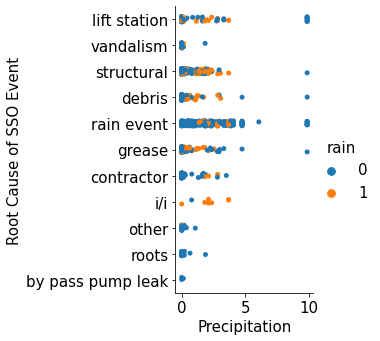



Hypothesis Testing:
H_null: Rain is not correlated as the cause of the pipe damage involving a root_cause.
H_alt: Rain is correlated as the cause of the pipe damage involving a root cause.

Root Causes: 
	structural, grease, debris, rain event, contractor, lift station, other, vandalism, roots, i/i, by pass pump leak, 

We reject the null hypothesis that rain is not correlated as the cause of the pipe damage invloving: 

 structural with an alpha of 0.01 and a p-value of 2.7445718289973744e-215:
 grease with an alpha of 0.01 and a p-value of 1.3740302046065684e-106:
 debris with an alpha of 0.01 and a p-value of 5.747169003132438e-80:
 rain event with an alpha of 0.01 and a p-value of 5.540496890241234e-71:
 contractor with an alpha of 0.01 and a p-value of 5.1456865189752425e-27:
 lift station with an alpha of 0.01 and a p-value of 1.5122709995154007e-24:
 other with an alpha of 0.01 and a p-value of 9.942851193120108e-10:
 vandalism with an alpha of 0.01 and a p-value of 4.95716665

In [10]:
explore.explore_rain(train)

**Main Hypothesis:** restated
- $H_0$: Rain and the root cause are not related.
- $H_a$: Rain and the root cause are related.

- since we reject the null hypothesis for the following root causes, we must reject the main null hypothesis:
    - structural 
    - grease 
    - debris
    - rain event
    - lift station
    - vandalism
    - contractor
    - i/i
    - other

### Does the temperature drive certain root causes?

#### Maximum Temperature

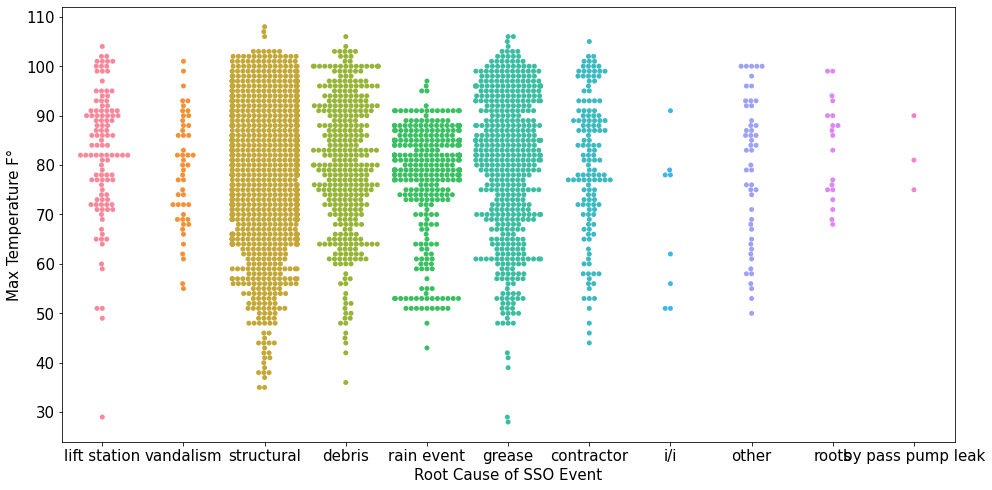



Hypothesis Testing:
H_null: Max tempurature is not correlated as the cause of the pipe damage involving a root_cause.
H_alt: Max tempurature is correlated as the cause of the pipe damage involving a root cause.

Root Causes: 
	structural, grease, debris, rain event, contractor, lift station, other, vandalism, roots, i/i, by pass pump leak, 

We reject the null hypothesis that max tempurature is not correlated as the cause of the pipe damage invloving: 

 lift station with an alpha of 0.01 and a p-value of 0.004931454391636043:
----------------------------------------------------------------------------------------------------
We fail to reject the null hypothesis that max tempurature is not correlated as the cause of the pipe damage invloving: 

 structural with an alpha of 0.01 and a p-value of 0.0437846982890007:
 grease with an alpha of 0.01 and a p-value of 0.1564421159023603:
 debris with an alpha of 0.01 and a p-value of 0.12488765473905385:
 rain event with an alpha of 0.01 an

In [11]:
explore.explore_max_temp(train)

**Main Hypothesis:** restated
- $H_0$: The high temperature of the day a SSO event occurred and the root cause are not related.
- $H_a$: The high temperature of the day a SSO event occurred and the root cause are related.

- since we reject the null hypothesis for the following root cause, we must to reject the main null hypothesis:
    - lift station

#### Minimum Temperature

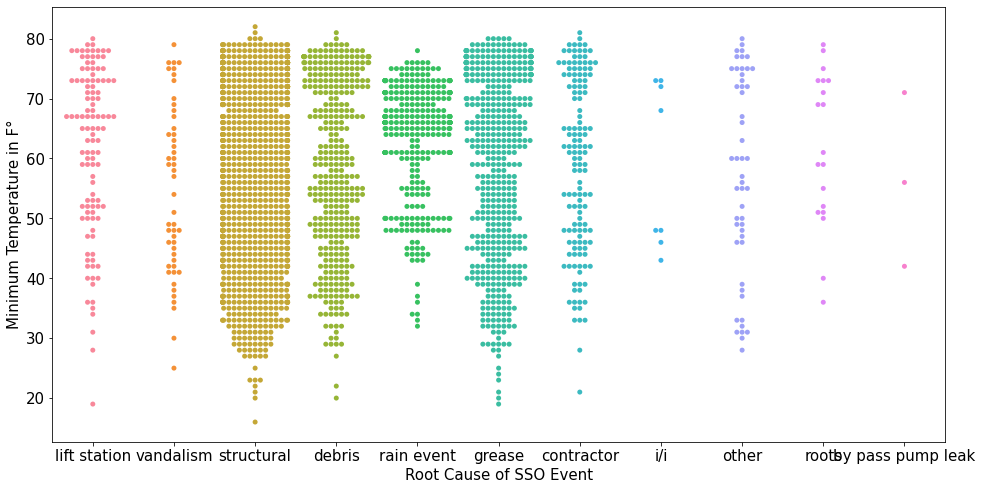



Hypothesis Testing:
H_null: Minimum temperature is not correlated as the cause of the pipe damage involving a root_cause.
H_alt: Minimum temperature is correlated as the cause of the pipe damage involving a root cause.

Root Causes: 
	structural, grease, debris, rain event, contractor, lift station, other, vandalism, roots, i/i, by pass pump leak, 

We reject the null hypothesis that minimum temperature is not correlated as the cause of the pipe damage invloving: 

 structural with an alpha of 0.01 and a p-value of 1.6974837821355497e-230:
 grease with an alpha of 0.01 and a p-value of 2.9636447577713094e-124:
 debris with an alpha of 0.01 and a p-value of 4.077871154900634e-102:
 rain event with an alpha of 0.01 and a p-value of 1.2688094408034376e-101:
 contractor with an alpha of 0.01 and a p-value of 1.7015445685265714e-38:
 lift station with an alpha of 0.01 and a p-value of 2.6401898559369945e-38:
 other with an alpha of 0.01 and a p-value of 1.327484174125047e-13:
 vandalism w

In [12]:
explore.explore_min_temp(train)

**Main Hypothesis:** restated
- $H_0$: The low temperature of the day a SSO event occurred and the root cause are not related.
- $H_a$: The low temperature of the day a SSO event occurred and the root cause are not related.

- since we reject the null hypothesis for the following root causes, we must reject the main null hypothesis:
    - structural 
    - rain event

#### Average Temperature

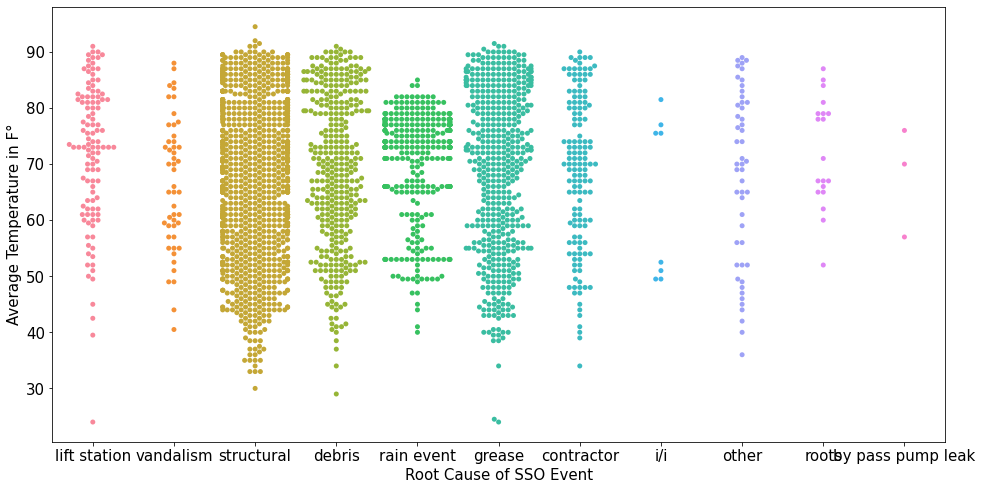



Hypothesis Testing:
H_null: The average temperature is not correlated as the cause of the pipe damage involving a root_cause.
H_alt: The average temperature is correlated as the cause of the pipe damage involving a root cause.

Root Causes: 
	structural, grease, debris, rain event, contractor, lift station, other, vandalism, roots, i/i, by pass pump leak, 

We reject the null hypothesis that the average temperature is not correlated as the cause of the pipe damage invloving: 

 structural with an alpha of 0.01 and a p-value of 0.0032301723907314592:
 rain event with an alpha of 0.01 and a p-value of 0.0005279598786638425:
 lift station with an alpha of 0.01 and a p-value of 0.004562725756672607:
----------------------------------------------------------------------------------------------------
We fail to reject the null hypothesis that the average temperature is not correlated as the cause of the pipe damage invloving: 

 grease with an alpha of 0.01 and a p-value of 0.4631409969994

In [13]:
explore.explore_avg_temp(train)

**Main Hypothesis:** restated
- $H_0$: The average temperature of the day a SSO event occurred and the root cause are not related.
- $H_a$: The average temperature of the day a SSO event occurred and the root cause are not related.

- since we reject the null hypothesis for the following root causes, we must reject the main null hypothesis:
    - structural 
    - rain event
    - lift station

## Modeling

### Prepocessing

* What are we changing?
    * We are removing several columns that we believe will not help the model
        * 'sso_id', 'report_date', 'spill_address_num', 'spill_st_name', 'spill_stop', 'spill_start', 'cause', 'comments', 'actions', 'month', 'year', 'week', 'spill_address_full', 'last_cleaned', 'response_dttm', 'prevspill_24mos', 'public_notice', 'country_address', 'location', 'inches_no', 'rainfall_last3', 'unit_id', 'unit_id2', 'zip_code', 'discharge_to', 'discharge_route', 'council_district', 'time_spilled', 'hrs', 'gals_ret', 'pipe_diam', 'pipe_len', 'response_time', 'days_since_cleaned', 'age'
    * We are one hot encoding the categorical columns
        * "watershed", "earz_zone", "pipe_type", "inst_year", "unit_type", "asset_type", "age_binned", "total_gal_binned"

In [14]:
df = preprocessing.get_model_data()
df

,total_gal,pipe_diam,pipe_len,num_spills_recorded,num_spills_24mos,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,age,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30,watershed_is_salado creek,watershed_is_dos rios,watershed_is_medio creek,watershed_is_leon creek,watershed_is_ccma (subscriber),earz_zone_is_0,earz_zone_is_5,earz_zone_is_3,earz_zone_is_1,earz_zone_is_4,earz_zone_is_2,pipe_type_is_pvc,pipe_type_is_cp,pipe_type_is_rl,pipe_type_is_vcp,pipe_type_is_unknown,pipe_type_is_cas,pipe_type_is_hdpe,pipe_type_is_rcp,pipe_type_is_dip,pipe_type_is_frp,pipe_type_is_ct,pipe_type_is_csc,pipe_type_is_,pipe_type_is_pick bar,pipe_type_is_xxx,pipe_type_is_ac,pipe_type_is_br,pipe_type_is_smartlid,inst_year_is_1997.0,inst_year_is_1988.0,inst_year_is_1955.0,inst_year_is_1983.0,inst_year_is_1952.0,inst_year_is_1992.0,inst_year_is_1985.0,inst_year_is_2015.0,inst_year_is_1956.0,inst_year_is_1987.0,inst_year_is_2011.0,inst_year_is_2007.0,inst_year_is_1962.0,inst_year_is_unknown,inst_year_is_2005.0,inst_year_is_2006.0,inst_year_is_1979.0,inst_year_is_2016.0,inst_year_is_1961.0,inst_year_is_2001.0,inst_year_is_2014.0,inst_year_is_1972.0,inst_year_is_1982.0,inst_year_is_2012.0,inst_year_is_1973.0,inst_year_is_1965.0,inst_year_is_1948.0,inst_year_is_1986.0,inst_year_is_2004.0,inst_year_is_1971.0,inst_year_is_1975.0,inst_year_is_1989.0,inst_year_is_1981.0,inst_year_is_1966.0,inst_year_is_1984.0,inst_year_is_1974.0,inst_year_is_1927.0,inst_year_is_2003.0,inst_year_is_1998.0,inst_year_is_1976.0,inst_year_is_1967.0,inst_year_is_1994.0,inst_year_is_1977.0,inst_year_is_1960.0,inst_year_is_1950.0,inst_year_is_1990.0,inst_year_is_1964.0,inst_year_is_1949.0,inst_year_is_1959.0,inst_year_is_1900.0,inst_year_is_1970.0,inst_year_is_1963.0,inst_year_is_2002.0,inst_year_is_1969.0,inst_year_is_1958.0,inst_year_is_2009.0,inst_year_is_1999.0,inst_year_is_1954.0,inst_year_is_2013.0,inst_year_is_1910.0,inst_year_is_1928.0,inst_year_is_1968.0,inst_year_is_2008.0,inst_year_is_1951.0,inst_year_is_1946.0,inst_year_is_2000.0,inst_year_is_1920.0,inst_year_is_1957.0,inst_year_is_1939.0,inst_year_is_1899.0,inst_year_is_1930.0,inst_year_is_2010.0,inst_year_is_1925.0,inst_year_is_1978.0,inst_year_is_1947.0,inst_year_is_2017.0,inst_year_is_1953.0,inst_year_is_1980.0,inst_year_is_1995.0,inst_year_is_1909.0,inst_year_is_1991.0,inst_year_is_1993.0,inst_year_is_1911.0,inst_year_is_1923.0,inst_year_is_1996.0,inst_year_is_1944.0,inst_year_is_1934.0,inst_year_is_1929.0,inst_year_is_1915.0,inst_year_is_1945.0,inst_year_is_1935.0,inst_year_is_1940.0,inst_year_is_1926.0,inst_year_is_1937.0,inst_year_is_1906.0,inst_year_is_1912.0,inst_year_is_1918.0,inst_year_is_1916.0,inst_year_is_1904.0,inst_year_is_1931.0,inst_year_is_1922.0,inst_year_is_1921.0,inst_year_is_1941.0,inst_year_is_1914.0,inst_year_is_1933.0,unit_type_is_gravity,unit_type_is_lateral,unit_type_is_submersed,unit_type_is_force,unit_type_is_pmpsubm,unit_type_is_siphon,unit_type_is_outfall,unit_type_is_unknown,unit_type_is_other,unit_type_is_above,unit_type_is_junction,unit_type_is_standard,unit_type_is_,unit_type_is_out siphon,unit_type_is_a/r,unit_type_is_in siphon,unit_type_is_pmpcentsp,unit_type_is_tankholdin,unit_type_is_sludge,asset_type_is_sewer main,asset_type_is_sewer service line,asset_type_is_sewer liftstation,asset_type_is_sewer force main,asset_type_is_sewer pump,asset_type_is_sewer node,asset_type_is_sewer lift station,asset_type_is_bypass,asset_type_is_sewer manhole,asset_type_is_sewer miscellaneous,asset_type_is_sewer treatment plant,asset_type_is_sewer valve,asset_type_is_bypass line,asset_type_is_unknown,asset_type_is_plant equipment,"age_binned_is_(20.0, 25.0]","age_binned_is_(30.0, 35.0]","age_

### Decision Tree Model

#### Let's split the data

In [15]:
X = df.drop(columns='root_cause')
y = df.root_cause

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

#### Now let's make the model. Through testing we found the the best parameters for our model to be the following:

In [16]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, criterion='entropy', random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score on Train: {tree.score(X_train, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score on Train: 55.86%
Accuracy Score on Val: 50.25%


#### We can see that our model doesn't appear to be overfit.
#### Let's look at the classification report for the validation set.

In [17]:
preds = tree.predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

  contractor       0.13      0.06      0.08        34
      debris       0.16      0.06      0.09        80
      grease       0.36      0.50      0.42       129
         i/i       0.00      0.00      0.00         2
lift station       0.89      0.89      0.89        27
       other       0.50      0.07      0.12        15
  rain event       0.73      0.85      0.79        74
       roots       0.00      0.00      0.00         2
  structural       0.55      0.65      0.60       211
   vandalism       0.00      0.00      0.00        15

    accuracy                           0.50       589
   macro avg       0.33      0.31      0.30       589
weighted avg       0.45      0.50      0.46       589



This report shows us we are getting:

- 68% on 246 structural
- 76% on 81 rain event
- 81% on 32 lift station
- 42% on 122 grease

In [18]:
print(f'These percentages equate to ' +\
f'{pd.Series([.68,.76,.81,.42]).mean()*100}% accuracy on ' +\
f'{round((246+81+32+122)/637*100,2)}% of the data')

These percentages equate to 66.75% accuracy on 75.51% of the data


#### The code below allows for us to look at how the tree is making decision.

In [19]:
dot_data = export_graphviz(tree, 
                           feature_names= X_train.columns.tolist(),
                           class_names= y_train.value_counts(normalize=True).index.sort_values().tolist(),
                           out_file=None) 
graph = graphviz.Source(dot_data) 

graph.render('saws-prediction-tree', view=True)

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'saws-prediction-tree'], make sure the Graphviz executables are on your systems' PATH

#### Since this was the best model we made let's see how it ran on the test data

In [ ]:
tree.score(X_test, y_test)

In [ ]:
preds = tree.predict(X_test)
print(classification_report(y_test, preds))